# 타이타닉 생존자 예측

## 라이브러리 및 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
titanic_df = pd.read_csv('data/ML_6_Titanic/train.csv')
titanic_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


### 컬럼의 의미
- PassengerId : 탑승자 데이터 일련번호
- Survived : 생존여부(0 = 사망, 1 = 생존)
- Pclass : 티켓의 선실 등급(1, 2, 3)
- Name : 탑승자 이름
- Sex : 탑승자 성별
- Age : 탑승자 나이
- SibSp : 탑승자와 함께 탑승한 형제자매 또는 배우자 인원수
- Parch : 같이 탑승한 부모님 또는 어린이 인원수
- Ticket : 티켓번호
- Fare : 요금
- Cabin : 선실 번호
- Embarked : 중간 정착 항구(C, Q, S)

In [3]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 데이터 가공

### 결측치 처리
- 숫자형 데이터인 Age는 평균 나이로 대체
- 나머지 범주형 데이터의 결측치는 N으로 대체

In [10]:
# Age - 평균나이 
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
# Cabin, Embarked - N
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)
# 결측치 확인
titanic_df.isnull().sum().sum()

0

### 범주형 데이터 결측치 처리
- value_counts() : 분류 확인하기

In [15]:
print(titanic_df['Sex'].value_counts())
print('\n', titanic_df['Cabin'].value_counts())
print('\n', titanic_df['Embarked'].value_counts())

Sex
male      577
female    314
Name: count, dtype: int64

 Cabin
N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: count, Length: 148, dtype: int64

 Embarked
S    644
C    168
Q     77
N      2
Name: count, dtype: int64


In [16]:
# Cabin에서 앞 알파벳만 추출하기
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
titanic_df['Cabin'].head(3)

0    N
1    C
2    N
Name: Cabin, dtype: object

## 탐색적 데이터 분석
- 사고가 날 경우 여성, 어린이, 노약자가 제일 먼저 구조 대상이 된다.
- 3등실에 탄 가난한 사람들은 우선순위에서 밀렸을 것이다.
- 따라서 성별이 생존 확률에 어떤 영향을 미치는 지 살펴보자.

In [17]:
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

<Axes: xlabel='Sex', ylabel='Survived'>

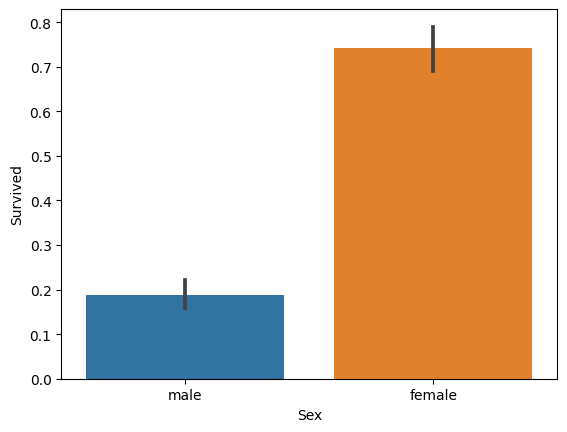

In [18]:
sns.barplot(data = titanic_df, x='Sex', y='Survived') 

- 객실 등급 별 생존확률

<Axes: xlabel='Pclass', ylabel='Survived'>

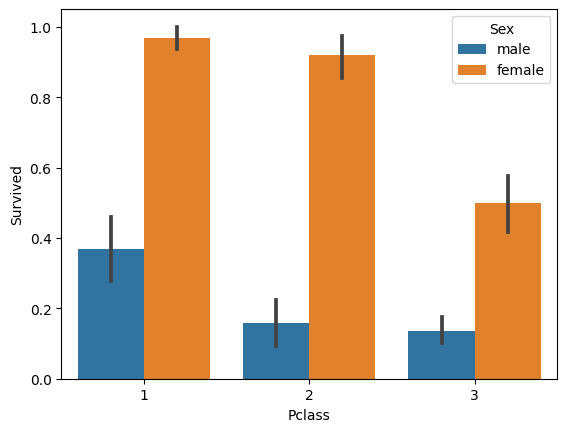

In [19]:
sns.barplot(data = titanic_df, x = 'Pclass' , y = 'Survived', hue='Sex')

- Age에 따른 생존 확률

In [28]:
# 입력 age에 따라 구분 값을 반환하는 함수 설정
def get_category(age):
    cat = ''
    if age <= -1 : cat = 'Unknown'
    elif age <= 5 : cat = 'Baby'
    elif age <= 12 : cat = 'Child'
    elif age <= 18 : cat = 'Teenager'
    elif age <= 25 : cat = 'Student'
    elif age <= 35 : cat = 'Young Adult'
    elif age <= 60 : cat = 'Adult'
    else : cat = 'Elderly'

    return cat

# x축 값을 순차적으로 표시하기 위한 설정
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult']

# lambda 식에 위에서 만든 함수를 반환값으로 지정
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
print(titanic_df[['Age', 'Age_cat']].head(1))

    Age  Age_cat
0  22.0  Student


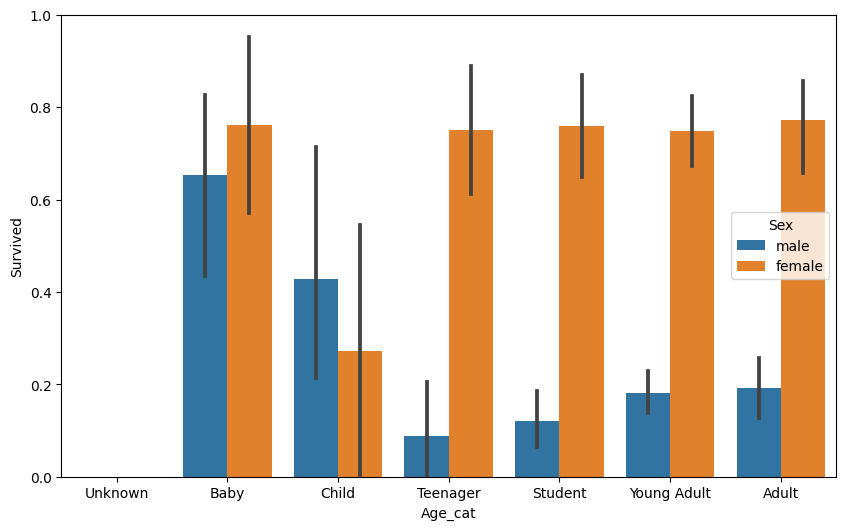

In [29]:
fig, ax = plt.subplots(figsize = (10, 6))
sns.barplot(data = titanic_df, x = 'Age_cat', y = 'Survived', hue = 'Sex', order = group_names)
plt.show()

- 지금까지 분석한 결과 Sex, Age, PClass 등이 생존을 좌우하는 피처임을 확인할 수 있었음

## 머신 러닝
### 문자열 카테고리 피처를 숫자형으로 변환 - 레이블 인코딩

In [30]:
titanic_df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,N,S,Student


In [32]:
from sklearn.preprocessing import LabelEncoder

def encode_features(dataDF):
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
    return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.25,7,3,Student


### 지금까지 피처 가공 내역을 함수로 정리하기

In [33]:
# Null 처리
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Cabin'].fillna('N', inplace = True)
    df['Embarked'].fillna('N', inplace = True)
    df['Fare'].fillna(0, inplace = True)
    return df

# 머신러닝 알고리즘에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

### 원본 데이터 재로딩 후 함수를 이용하여 가공(Survived 속성만 별도 분리하여 클래스 결정값 데이터 세트로 만들기)

In [34]:
# 원본 데이터 재로딩 후 Survived 속성만 분리, 피처 데이터 세트와 레이블 데이터 세트 추출
df = pd.read_csv('data/ML_6_Titanic/train.csv')
y_df = df['Survived']
X_df = df.drop('Survived', axis = 1)

X_df = transform_features(X_df)

In [35]:
X_df.shape, y_df.shape

((891, 8), (891,))

In [36]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int32  
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Cabin     891 non-null    int32  
 7   Embarked  891 non-null    int32  
dtypes: float64(2), int32(3), int64(3)
memory usage: 45.4 KB


### 훈련 데이터, 테스트 데이터 분리

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_df,
    y_df,
    test_size = 0.2, 
    random_state = 11
)

In [38]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 8), (179, 8), (712,), (179,))

### 알고리즘 호출

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정트리, 랜덤포레스트, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lf_clf = LogisticRegression(solver = 'liblinear')

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lf_clf.fit(X_train, y_train)
lf_pred = lf_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lf_pred)))

DecisionTreeClassifier 정확도: 0.7877
RandomForestClassifier 정확도: 0.8547
LogisticRegression 정확도: 0.8659


- 아직 최적화 수행하지 않았고 데이터 양이 충분하지 않아서 어느 알고리즘의 성능이 가장 좋다고 평가할 수는 없다.
- https://scikit-learn.org/stable/supervised_learning.html 여기에 있는 알고리즘들도 마찬가지로 적용하여 확인할 수도 있다. 

In [42]:
from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
nb_pred = nb_clf.predict(X_test)
print('GaussianNB 정확도: {0:.4f}'.format(accuracy_score(y_test, nb_pred)))

GaussianNB 정확도: 0.8212


### 교차 검증 - KFold

In [43]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
    # 폴드 세트가 5개인 KFold 객체 생성, 폴드 수만큼 예측 결과 저장을 위한 리스트 객체 생성
    kfold = KFold(n_splits = folds)
    scores = []

    # KFold 교차 검증 수행
    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_df)):
        # X_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = X_df.values[train_index], X_df.values[test_index]
        y_train, y_test = y_df.values[train_index], y_df.values[test_index]
        # Classifier 학습, 예측, 정확도 계산
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차 검층 {0} 정확도: {1:.4f}".format(iter_count, accuracy))

    # 5개 fold에서의 평균 정확도 계산
    mean_score = np.mean(scores)
    print("평균 정확도: {0:.4f}".format(mean_score))
# exec_kfold 호출
exec_kfold(dt_clf, folds=5)

교차 검층 0 정확도: 0.7542
교차 검층 1 정확도: 0.7809
교차 검층 2 정확도: 0.7865
교차 검층 3 정확도: 0.7697
교차 검층 4 정확도: 0.8202
평균 정확도: 0.7823


### 교차 검증 - cross_val_score()

In [45]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_df, y_df, cv=5)
for iter_count, accuracy in enumerate(scores):
    print("교차 검층 {0} 정확도: {1:.4f}".format(iter_count, accuracy))

print("평균 정확도: {0:.4f}".format(np.mean(scores)))

교차 검층 0 정확도: 0.7430
교차 검층 1 정확도: 0.7753
교차 검층 2 정확도: 0.7921
교차 검층 3 정확도: 0.7865
교차 검층 4 정확도: 0.8427
평균 정확도: 0.7879


### 최적 하이퍼 파라미터 찾고 예측 성능 측정하기

In [46]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': [2, 3, 5, 10],
             'min_samples_split': [2, 3, 5],
             'min_samples_leaf': [1, 5, 8]}
grid_dclf = GridSearchCV(dt_clf, param_grid = parameters, scoring = 'accuracy', cv = 5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터: ', grid_dclf.best_params_)
print("GridSearchCV 최고 정확도: {0:.4f}".format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print("테스트 세트에서의 DecisionTreeClassifier 정확도: {0:.4f}".format(accuracy))

GridSearchCV 최적 하이퍼 파라미터:  {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도: 0.8715
